In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import nibabel as nb
from nipype.interfaces.ants import Registration

In [3]:
ref = io.imread("/home/julia/data/gradients/atlas/interneurons/Reference-brain.tif")
pv = io.imread("/home/julia/data/gradients/atlas/interneurons/Parvalbumin-Vox.tif")
sst = io.imread("/home/julia/data/gradients/atlas/interneurons/Somatostatin-Vox.tif")
vip = io.imread("/home/julia/data/gradients/atlas/interneurons/VIP-Vox.tif")

In [68]:
ref.shape

(300, 450, 650)

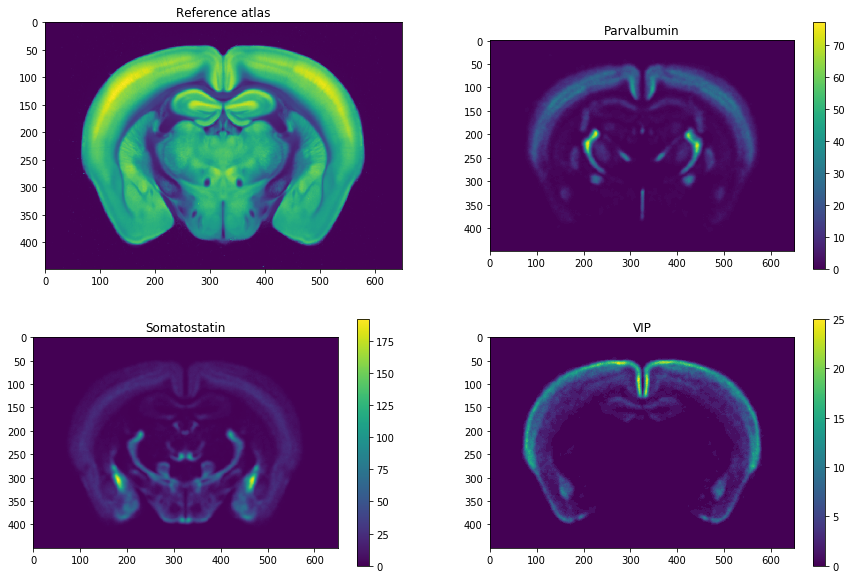

In [29]:
z = 150

fig = plt.figure(figsize=(15,10))
fig.add_subplot(2,2,1)
plt.imshow(ref[z,:,:])
plt.title('Reference atlas')
fig.add_subplot(2,2,2)
plt.imshow(pv[z,:,:])
plt.title('Parvalbumin')
plt.colorbar()
fig.add_subplot(2,2,3)
plt.imshow(sst[z,:,:])
plt.title('Somatostatin')
plt.colorbar()
fig.add_subplot(2,2,4)
plt.imshow(vip[z,:,:])
plt.colorbar()
plt.title('VIP');

In [114]:
allen = nb.load('/home/julia/data/gradients/atlas/allen_api/template.nii.gz').get_data()

In [118]:
print(allen.shape, ref.shape)

(528, 320, 456) (300, 450, 650)


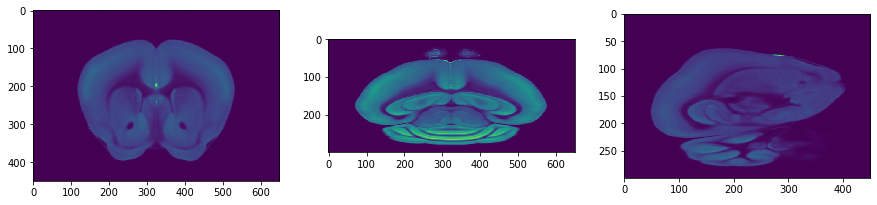

In [125]:
fig = plt.figure(figsize=(15,10))
fig.add_subplot(2,3,1)
plt.imshow(ref[100,:,:])
fig.add_subplot(2,3,2)
plt.imshow(ref[:,150,:])
fig.add_subplot(2,3,3)
plt.imshow(ref[:,:,200])

In [96]:
aff = nb.load('/home/julia/data/gradients/atlas/allen_api/cortex_mask_tight.nii.gz').affine
hdr = nb.load('/home/julia/data/gradients/atlas/allen_api/cortex_mask_tight.nii.gz').header
nb.save(nb.Nifti1Image(allen, aff, hdr), '/home/julia/data/gradients/atlas/allen_api/template.nii.gz')

In [111]:
aff_yongsoo = np.eye(4)
aff_yongsoo[0,0] = 0.05
aff_yongsoo[1,1] = 0.02
aff_yongsoo[2,2] = 0.02

In [113]:
nb.save(nb.Nifti1Image(ref, aff_yongsoo), '/home/julia/data/gradients/atlas/interneurons/Reference-brain.nii.gz')
nb.save(nb.Nifti1Image(pv, aff_yongsoo), '/home/julia/data/gradients/atlas/interneurons/Parvalbumin-Vox.nii.gz')
nb.save(nb.Nifti1Image(sst, aff_yongsoo), '/home/julia/data/gradients/atlas/interneurons/Somatostatin-Vox.nii.gz')
nb.save(nb.Nifti1Image(vip, aff_yongsoo), '/home/julia/data/gradients/atlas/interneurons/VIP-Vox.nii.gz')

### Registration with ants

In [ ]:
allen_img = '/home/julia/data/gradients/atlas/allen_api/template.nii.gz'
yongsoo_img = '/home/julia/data/gradients/atlas/interneurons/Reference-brain.nii.gz'
reg_struct = Registration(fixed_image = allen_img,
                          moving_image = yongsoo_img,
                          # in contrast to SAMRI included rigid step, CC for nonlinear, changed transform_parameters
                          dimension = 3,
                          transforms = ['Rigid','Affine', 'SyN'], 
                          metric = ['GC', 'MI','MI'], 
                          transform_parameters = [(0.1,), (0.1,), (0.1, 2.0, 0.2)],
                          metric_weight = [1, 1, 1],
                          radius_or_number_of_bins = [64, 16, 16],
                          sampling_percentage = [0.2, 0.3, 0.3],
                          sampling_strategy = ['Regular', None, None],
                          convergence_threshold = [1.e-16, 1.e-32, 1.e-8],
                          convergence_window_size = [30, 30, 30],
                          smoothing_sigmas = [[1, 0], [1, 0], [1, 0]], # reduces this a lot compared to SAMRI (4,2,1)
                          sigma_units = ['vox', 'vox', 'vox'],
                          shrink_factors = [[2, 1],[1, 1], [1, 1]],
                          use_estimate_learning_rate_once = [False, False, False], # if the fixed_image is not acquired similarly to the moving_image (e.g. RARE to histological (e.g. AMBMC)) this should be False
                          use_histogram_matching = [True, True, True],
                          number_of_iterations = [[3000, 2000], [500, 250], [500, 250]],
                          write_composite_transform = True,
                          collapse_output_transforms = True,
                          winsorize_lower_quantile = 0.005,
                          winsorize_upper_quantile = 0.995,
                          args = '--float',
                          num_threads = 4,
                          initial_moving_transform_com = True,
                         )
reg_struct.run()